In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
import modules.eda as Detective
import modules.model as Model
import pandas as pd
import warnings
import numpy as np
import emojis
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

warnings.filterwarnings('ignore')

In [3]:
def expandEmojisDecode(pcomment: str):
    expand_emojis = ''
    for e in emojis.get(pcomment):
        amount = pcomment.count(e)
        expand_emojis += (f"{emojis.decode(e)[1:-1]} ")*amount
        
    return expand_emojis.strip()

In [4]:
reviews = pd.read_csv("./data/normalize_reviews.csv").fillna("")
reviews = reviews[['raw_comment', 'normalize_comment', 'emoji', 'label']]

reviews.head()

,raw_comment,normalize_comment,emoji,label
0,Giao hàng kh đúng cần phê bình hjjjjjhhd...,giao hàng không đúng cần phê bình,,0
1,Chất lượng sản phẩm tạm được. Giao...,chất lượng sản phẩm tạm được giao ...,,0
2,Ko có lắc tay như hình,không có lắc tay như hình,,0
3,Giao hàng lâu. Bảo có lắc tay mà k thâ...,giao hàng lâu bảo có lắc tay mà không ...,,0
4,"Mình mua 2 cái, một dùng ok. Một cái k...",mua cái một dùng ok một cái không chạ...,😢,0


Hiện tại, dataset chúng ta có hai feature là `normalize_comment` và `emoji`, chúng ta có thể xây dựng một sentiment analysis classifier bằng hai cách:
  * **Cách 1**: Chúng ta có thể đem feature `emoji` để thêm vào phần đầu hoặc cuối của feature `normalize_comment`. Sau đó tiến hành đào tạo một model duy nhất với input là feature `normalize_comment` đã được thêm vào feature `emoji`.
    * Ưu điểm: Quá trình đào tạo model đỡ tốn thời gian hơn do ta chỉ thực hiện build một model duy nhất.
    * Nhược điểm:
      * Có khả năng làm suy giảm sức mạnh của model, nhiều người họ còn xây dưng riêng một **emoji classifier** bởi vì theo họ nhiều khi emoji đó mang lại ý nghĩa thậm chí còn cao hơn so với ngữ nghĩa của comment đó. Trong khi việc đào tạo một emoji classifier đỡ vất vã hơn.
      * Ta phải tốn thời gian vào việc xây dựng thêm một model riêng sau đó lại tổng hợp kết quả của emoji classifier model này với sentiment classifier model ban đầu.
  * **Cách 2**: Ta có thể xây dựng hai model riêng biệt, một sentiment analysis model đảm nhận nhiệm vụ phân lớp cho câu chữ và một emoji analysis model đảm nhận nhiệm vụ phân lớp trên emoji. Sau đó ta kết hợp hai model này để cho ra kết quả phân lớp cuối cùng.
    * Ưu điểm: Kết quả phân lớp cho ra có khả năng chính xác hơn, ta có thể linh hoạt trong việc thiếp lập trọng số để ưu tiên giá trị của model nào mang lại lợi ích cao hơn cho kết quả ở bước kết hợp hai model lại để dự đoán.
    * Nhược điểm:
      * Vất vả hơn về mặt tiền xử lí dữ liệu, tốn thêm thời gian phân tích và thiết kế thêm một emoji classifier.
      * Phần lớn trong dataset hiện tại, số comment chứa emoji không nhiều. Như project 2 ta đã thấy toàn bộ dataset của ta chỉ khoảng 1300 comment là có chứa emoji kèm theo, ta có thể khắc phục bằng một trong những cách:
        * Crawl thêm data, nhưng việc này không khả khi. Ta đã đề cập rằng số comment chứa emoji rất ít trong một dataset nên việc ta hi sinh thời gian chỉ để trích xuất một phần nhỏ trong một dataset cực lớn sau khi crawl về có thể phí phạm.
        * Sử dụng kĩ thuật **Data Upsampler** với package của IBM `from imblearn.over_sampling import RandomOverSampler`.

    $\Rightarrow$ Hướng giải quyết: Quả thật ta có khoảng 1300 observer thì là một con số không quá ít cũng không quá nhiều, số lượng emoji chứa trong một comment cũng không nhiều (không tính các duplicate emoji). Bài toán của chúng ta đơn thuần chỉ là phân tích các emoji ra hai class là negative và positive. Hãy cùng nhìn lại một dataset nổi tiếng khác là **Iris**, ta có 3 class ở target variable và 150 observe. Vậy ta vẫn có thể build một classifier model đủ tốt nếu input của ta cũng **đủ tốt**.

# Emoji sentiment analysis

Như vậy chiến lược đào tạo một Emoji sentiment analysis của chúng ta sẽ như sau:
  * Bước 1: Tiến hành lấy toàn bộ các emoji trong các comment và lưu trong cấu trúc dữ liệu `set`, mục tiêu ta cần biết có bao nhiêu unique emoji trong dataset của chúng ta.
  * Bước 2: Tạo 2 dictionary, một dictionary có key là emoji và value là index của emoji đó trong `set`, dictionary thứ hai có key là index của emoji trong `set` và value là emoji.
  * Bước 3: Giả sử có $n$ unique emoji trong dataset, ta sẽ chỉ quan tâm đến các comment chứa emoji, và với từng comment như vậy ta tạo một vector $n$ phần tử sau đó áp dụng phương pháp **Bag of words** lên vector này.
  * Bước 4: Xem xét $n$ có lớn không, nếu quá lớn thì có thể áp dụng các phương pháp giảm chiều dữ liệu.
  * Bước 5: Dùng các vector $n$ phần tử + label của chúng sau khi đã qua bước 4 để đào tạo một classifier model.

Bây giờ ta sẽ tiến hành lọc ra nhựng comment mà có chứa emoji dựa vào feature `emoji`. Sau đó lưu các observe này vào biến `emojis`.

In [5]:
data = reviews[reviews['emoji'] != ""]

data

,raw_comment,normalize_comment,emoji,label
4,"Mình mua 2 cái, một dùng ok. Một cái k...",mua cái một dùng ok một cái không chạ...,😢,0
15,Giao sai màu sai size có 1 dép lông size 3...,giao sai màu sai size có dép lông size à ...,🤬,0
30,Đơn hàng đã thanh toán airpay rồi mà sh...,đơn hàng thanh toán mà giao cho người l...,🙄,0
43,Áo croptop freesize rộng với mình \nMìn...,áo rộng mình kg,👍,0
47,Khá buồn . Đặt 2 cái đều không chạy ...,khá buồn đặt cái đều không chạy giơ...,♀️ 🤷,0
...,...,...,...,...
14184,"Không mua hối hận đừng kêu nhá haha, ...",không mua hối hận đừng kêu nhá hàng ...,😂,1
14186,khuyên xinh lắm lúc mình đặt còn đươ...,khuyên xinh lắm lúc đặt còn được dea...,😘,1
14193,đẹp rẻ chất lượng vô cùng xịn 😗😗😗 ma...,đẹp rẻ chất lượng vô cùng xịn mãi u...,😗,1
14194,"Đẹp, sẽ ủng hộ tiếp nhé 👕👕👕👕👕👕👕👕👕👕👕👕👕👕...",đẹp sẽ ủng hộ tiếp nhé,👕,1


Package **emojis** chỉ hỗ trợ chức năng tách emoji ra khỏi text, nó không hỗ trợ thống kê là một emoji xuất hiện bao nhiêu lần trong text đó. Bây giờ ta sẽ tách các emoji trong comment ra nhưng vẫn bảo toàn về mặt số lượng ban đầu của nó trong feature `raw_comment` và lưu vào feature `emoji`.

In [6]:
data['decode_emoji'] = data['raw_comment'].apply(lambda cmt: expandEmojisDecode(cmt))

data

,raw_comment,normalize_comment,emoji,label,decode_emoji
4,"Mình mua 2 cái, một dùng ok. Một cái k...",mua cái một dùng ok một cái không chạ...,😢,0,cry
15,Giao sai màu sai size có 1 dép lông size 3...,giao sai màu sai size có dép lông size à ...,🤬,0,cursing_face cursing_face cursing_face
30,Đơn hàng đã thanh toán airpay rồi mà sh...,đơn hàng thanh toán mà giao cho người l...,🙄,0,roll_eyes
43,Áo croptop freesize rộng với mình \nMìn...,áo rộng mình kg,👍,0,thumbsup thumbsup thumbsup thumbsup thumbsup t...
47,Khá buồn . Đặt 2 cái đều không chạy ...,khá buồn đặt cái đều không chạy giơ...,♀️ 🤷,0,shrug female_sign
...,...,...,...,...,...
14184,"Không mua hối hận đừng kêu nhá haha, ...",không mua hối hận đừng kêu nhá hàng ...,😂,1,joy
14186,khuyên xinh lắm lúc mình đặt còn đươ...,khuyên xinh lắm lúc đặt còn được dea...,😘,1,kissing_heart kissing_heart kissing_heart
14193,đẹp rẻ chất lượng vô cùng xịn 😗😗😗 ma...,đẹp rẻ chất lượng vô cùng xịn mãi u...,😗,1,kissing kissing kissing kissing kissing kissin...
14194,"Đẹp, sẽ ủng hộ tiếp nhé 👕👕👕👕👕👕👕👕👕👕👕👕👕👕...",đẹp sẽ ủng hộ tiếp nhé,👕,1,tshirt tshirt tshirt tshirt tshirt tshirt tshi...


Bước này, ta thực hiện chia `emojis` ra thành hai tập training data và test data với test data chiếm 20% số lượng các observer của `emojis`.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['decode_emoji'], data['label'], test_size=0.2, random_state=42)

In [8]:
X_train

1521                                            heart_eyes
11485    kissing_heart kissing_heart kissing_heart hear...
3467                                              relieved
7740     sob sob sob persevere persevere persevere pers...
12870                                          heart heart
                               ...                        
12351                                           gift_heart
12799                                                heart
13056                                            wink hugs
10730    blush blush blush blush blush blush blush blus...
13032                                                 wink
Name: decode_emoji, Length: 1026, dtype: object

Bây giờ, chúng ta thực hiện kĩ thuật **vectorizing text**, ta áp dụng lần lượt hai phương pháp là **Bag of Words** và **TF-IDF**.

In [9]:
# Bag of words
bow_vec = CountVectorizer()
bow_emojis = bow_vec.fit_transform(X_train)

print(bow_vec.get_feature_names())
print(bow_emojis.toarray())

['100', 'anger', 'angry', 'ballet_shoes', 'bangbang', 'birthday', 'blossom', 'blue_heart', 'blush', 'bouquet', 'bow', 'broken_heart', 'butterfly', 'cake', 'camera', 'carrot', 'cherry_blossom', 'clap', 'cloud_with_rain', 'clown_face', 'cold_face', 'cold_sweat', 'compass', 'confounded', 'confused', 'cow', 'crossed_fingers', 'cry', 'crying_cat_face', 'cursing_face', 'disappointed', 'disappointed_relieved', 'dizzy', 'dizzy_face', 'dog', 'dog2', 'dollar', 'eagle', 'expressionless', 'face_with_thermometer', 'facepalm', 'fallen_leaf', 'fearful', 'female_sign', 'fire', 'fist_left', 'floppy_disk', 'flushed', 'four_leaf_clover', 'free', 'frowning_face', 'fu', 'ghost', 'gift_heart', 'golf', 'green_heart', 'green_salad', 'grimacing', 'grin', 'grinning', 'haircut', 'hand_over_mouth', 'hatched_chick', 'heart', 'heart_eyes', 'heart_eyes_cat', 'heartbeat', 'heartpulse', 'hearts', 'heavy_check_mark', 'heavy_heart_exclamation', 'hibiscus', 'high_brightness', 'hugs', 'information_desk_person', 'innocent'

In [10]:
tfidf_vec = TfidfVectorizer()
tfidf_emojis = tfidf_vec.fit_transform(X_train)

print(tfidf_emojis.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
X_vectorizers = [
    ('Bag of Words', bow_emojis),
    ('TF-IDF', tfidf_emojis)
]

Bây giờ ta liệt kê tất cả các model mà ta có thể ap dụng vào bài toán Binary Classification vào một list object.

In [12]:
lst_models = [
    ('Logistic Regression - [solver: lbfgs]', LogisticRegression(solver='lbfgs')),
    ('Logistic Regression - [solver: liblinear]', LogisticRegression(solver='liblinear')),
    ('Logistic Regression - [solver: newton-cg]', LogisticRegression(solver='newton-cg')),
    ('KNN - [n_neighbors: 2]', KNeighborsClassifier(n_neighbors=2)),
    ('KNN - [n_neighbors: 3]', KNeighborsClassifier(n_neighbors=3)),
    ('SVC - [kernel: linear]', SVC(kernel='linear', random_state=42)),
    ('SVC - [kernel: poly]', SVC(kernel='poly', random_state=42)),
    ('SVC - [kernel: rbf]', SVC(kernel='rbf', random_state=42)),
    ('SVC - [kernel: sigmoid]', SVC(kernel='sigmoid', random_state=42)),
    ('Bernoulli', BernoulliNB()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=42), random_state=42)),
    ('XGBoost', XGBClassifier(eval_metric='mlogloss'))
]

In [13]:
def train(lst_models, X_vectorizer, y, cv):
    res_table = []
    for vec_name, X in X_vectorizer:
        for mdl_name, model in lst_models:
            cv_res = cross_validate(model, X, y, cv=cv, return_train_score=True, scoring=['accuracy', 'roc_auc'])
            res_table.append([vec_name, mdl_name,
                              cv_res['train_accuracy'].mean(),
                              cv_res['test_accuracy'].mean(),
                              np.abs(cv_res['train_accuracy'].mean() - cv_res['test_accuracy'].mean()),
                              cv_res['train_accuracy'].std(),
                              cv_res['test_accuracy'].std(),
                              cv_res['train_roc_auc'].mean(),
                              cv_res['test_roc_auc'].mean(),
                              np.abs(cv_res['train_roc_auc'].mean() - cv_res['test_roc_auc'].mean()),
                              cv_res['train_roc_auc'].std(),
                              cv_res['test_roc_auc'].std(),
                              cv_res['fit_time'].mean()
            ])
    
    res_table = pd.DataFrame(res_table, columns=['vectorizer', 'model', 'train_acc', 'test_acc', 'diff_acc',
                                                 'train_acc_std', 'test_acc_std', 'train_roc_auc', 'test_roc_auc',
                                                 'diff_roc_auc', 'train_roc_auc_std', 'test_roc_auc_std', 'fit_time'])
    res_table.sort_values(by=['test_acc', 'test_roc_auc'], ascending=False, inplace=True)
    return res_table.reset_index(drop=True)

In [14]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
res_models = train(lst_models, X_vectorizers, y_train, cv)

res_models

,vectorizer,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,TF-IDF,SVC - [kernel: rbf],0.893546,0.851875,0.041671,0.003487,0.038218,0.905123,0.873282,0.031841,0.016902,0.033987,0.017995
1,TF-IDF,Logistic Regression - [solver: liblinear],0.890189,0.850866,0.039322,0.004251,0.033072,0.930616,0.903272,0.027344,0.003066,0.036520,0.001930
2,TF-IDF,Logistic Regression - [solver: lbfgs],0.890189,0.850866,0.039322,0.004251,0.033072,0.930633,0.903188,0.027445,0.003078,0.036723,0.013140
3,TF-IDF,Logistic Regression - [solver: newton-cg],0.890189,0.850866,0.039322,0.004251,0.033072,0.930635,0.903188,0.027447,0.003078,0.036723,0.023318
4,TF-IDF,Random Forest,0.900802,0.847944,0.052858,0.003933,0.045535,0.957656,0.897262,0.060395,0.002273,0.035206,0.212158
5,TF-IDF,SVC - [kernel: poly],0.896578,0.847002,0.049576,0.003524,0.039243,0.905438,0.854690,0.050747,0.006277,0.044771,0.019086
6,Bag of Words,Bernoulli,0.882933,0.845012,0.037920,0.003072,0.034061,0.937264,0.898412,0.038853,0.002624,0.032872,0.001816
7,TF-IDF,Bernoulli,0.882933,0.845012,0.037920,0.003072,0.034061,0.937264,0.898412,0.038853,0.002624,0.032872,0.001796
8,TF-IDF,SVC - [kernel: sigmoid],0.881200,0.844080,0.037121,0.003237,0.037964,0.908762,0.881717,0.027045,0.010184,0.043808,0.013976
9,TF-IDF,SVC - [kernel: linear],0.887698,0.843118,0.044580,0.003094,0.036253,0.908829,0.870945,0.037883,0.011004,0.034686,0.011566


In [15]:
Model.emojiEvaluationGroupedBarChart(res_models)

> **Nhận xét**:
> * Bảng trên là thống kê về các chỉ số **accuracy** và **ROC-AUC** của 26 model được **sắp xếp giảm dần** dựa trên **valuation accuracy** _(trong sklearn định nghĩa là `test_accuracy`)_ và **valuation ROC-AUC** _(trong sklearn định nghĩa là `test_roc_auc`)_.
> * Có thể thấy, sự khác biệt giữa các metric trên **train** và **valuation** là không quá lớn _(xem vào `diff_acc` và `diff_roc_auc`)_, trung bình có thể thấy chúng dao động dưới 5%. $\Rightarrow$ Các model của chúng ta không bị overfitting.
> * Số ít ở các model KNN và AdaBoost có các chỉ số đánh giá cho kết quả không tốt vì chúng dao động xung quanh 10% $\Rightarrow$ Hai thuật toán này không phù hợp với bài toán Emoji sentiment analysis trên dataset của chúng ta.
> * Phương pháp text vectorizing **TF-IDF** hoạt động tốt hơn **Bag of words**, có thể thấy ở 10 model cho hiệu suất tốt nhất thì phương pháp **TF-IDF** chiếm lĩnh toàn bộ trong việc đưa ra một cách tối ưu hóa đầu vào tốt trên các model.
> * Về evaluation, cả **train/valuation accuracy** và **train/valuation ROC-AUC** khá tốt, luôn thuộc phạm vi $[80, 100]\%$ ở 10 model đầu tiên. 
> * Như vậy, các model của chúng ta không bị overfitting cũng như bias và variance error. Ta có thể chọn ra 3 model đầu tiên để tiến hành Tunning Hyperparameters.

In [40]:
models_tunning = [
    ('SVC - [kernel:rbf]', SVC(kernel='rbf', random_state=42), 
     {'C': [1, 10, 50, 70, 100, 120, 150, 170, 200],
      'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}),
    ('Logistic Regression - [solver: liblinear]', LogisticRegression(solver='liblinear'),
     {'penalty': ['l1', 'l2'],
      'C': [0.001,0.01,0.1,1,10,100,1000]}),
    ('Random Forest', RandomForestClassifier(random_state=42),
     {'bootstrap': [False, True],
      'max_depth': [None, 10, 30, 50],
      'max_features': ["auto", "sqrt", "log2"],
      'n_estimators': [100, 200]})
]

In [41]:
def tunningModel(lst_models, X_vectorizer, y, cv):
    models_final = []
    for model_name, model, params in lst_models:
        tic = time.time()
        search = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring=['accuracy', 'roc_auc'], refit='accuracy')
        search.fit(X_vectorizer, y)
        model_tunned = model.set_params(**search.best_params_)
        models_final.append((model_name, model_tunned))
        toc = time.time()
        print('Model {} have been tunned in {:,.2f} seconds'.format(model_name, (toc-tic)))
        
    return models_final

In [42]:
models_final = tunningModel(models_tunning, tfidf_emojis, y_train, cv=cv)

models_final

Model SVC - [kernel:rbf] have been tunned in 17.70 seconds
Model Logistic Regression - [solver: liblinear] have been tunned in 1.40 seconds
Model Random Forest have been tunned in 208.17 seconds


[('SVC - [kernel:rbf]', SVC(C=1, random_state=42)),
 ('Logistic Regression - [solver: liblinear]',
  LogisticRegression(C=1, solver='liblinear')),
 ('Random Forest',
  RandomForestClassifier(max_depth=50, max_features='log2', n_estimators=200,
                         random_state=42))]

In [44]:
res_tunning_models = train(models_final, [("TF-IDF", tfidf_emojis)], y_train, cv)

res_tunning_models

,vectorizer,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,TF-IDF,Random Forest,0.895604,0.853779,0.041825,0.003544,0.039127,0.946001,0.906505,0.039495,0.002755,0.037317,0.391599
1,TF-IDF,SVC - [kernel:rbf],0.893546,0.851875,0.041671,0.003487,0.038218,0.905123,0.873282,0.031841,0.016902,0.033987,0.016637
2,TF-IDF,Logistic Regression - [solver: liblinear],0.890189,0.850866,0.039322,0.004251,0.033072,0.930616,0.903272,0.027344,0.003066,0.036520,0.002032


In [46]:
def evaluation(tunning_models, X_train_vec, y_train, X_test_vec, y_test):
    res = []
    for name, model in tunning_models:
        model.fit(X_train_vec, y_train)
        y_train_pred = model.predict(X_train_vec)
        y_test_pred = model.predict(X_test_vec)
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_roc_auc = roc_auc_score(y_train, y_train_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_pred)
        res.append([name, train_acc, test_acc, train_roc_auc, test_roc_auc])
        
    res = pd.DataFrame(res, columns=['model', 'train_acc', 'test_acc', 'train_roc_auc', 'test_roc_auc'])
    res.sort_values(by=['test_acc', 'test_roc_auc'], ascending=False, inplace=True)
    
    return res.reset_index(drop=True)

In [47]:
tfidf_test_emojis = tfidf_vec.transform(X_test)
models_best = evaluation(models_final, tfidf_emojis, y_train, tfidf_test_emojis, y_test)

models_best

,model,train_acc,test_acc,train_roc_auc,test_roc_auc
0,Logistic Regression - [solver: liblinear],0.887914,0.824903,0.865063,0.790367
1,SVC - [kernel:rbf],0.891813,0.821012,0.869359,0.791302
2,Random Forest,0.887914,0.817121,0.857878,0.780058


In [55]:
model = models_final[0][1]
model.fit(tfidf_emojis, y_train)

y_train_pred = model.predict(tfidf_emojis)
y_test_pred = model.predict(tfidf_test_emojis)

              precision    recall  f1-score   support

    Negative       0.88      0.80      0.84       357
    Positive       0.90      0.94      0.92       669

    accuracy                           0.89      1026
   macro avg       0.89      0.87      0.88      1026
weighted avg       0.89      0.89      0.89      1026



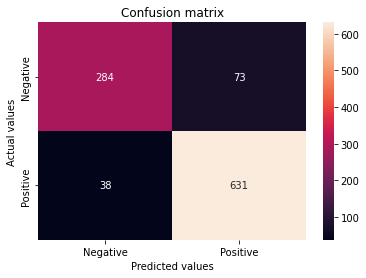

In [57]:
Model.confusionMatrix(y_train, y_train_pred, ['Negative', 'Positive'])

              precision    recall  f1-score   support

    Negative       0.82      0.67      0.74        97
    Positive       0.82      0.91      0.86       160

    accuracy                           0.82       257
   macro avg       0.82      0.79      0.80       257
weighted avg       0.82      0.82      0.82       257



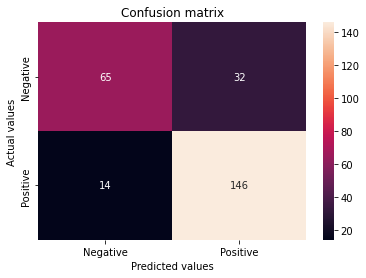

In [58]:
Model.confusionMatrix(y_test, y_test_pred, ['Negative', 'Positive'])

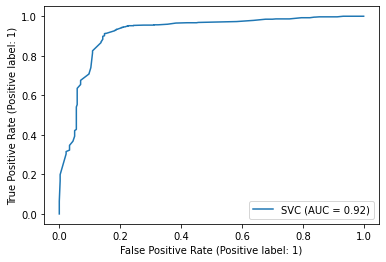

In [60]:
Model.rocAuc(model, tfidf_emojis, y_train)

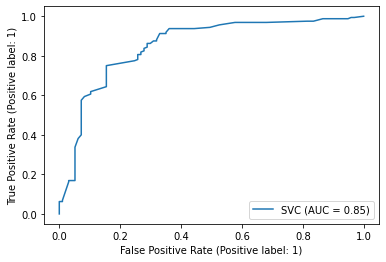

In [61]:
Model.rocAuc(model, tfidf_test_emojis, y_test)

In [62]:
Model.saveByPickle(tfidf_vec, "./models/tfidf_vectorizer_emojis.pickle")

TfidfVectorizer() has been saved at ./models/tfidf_vectorizer_emojis.pickle.


In [63]:
Model.saveByPickle(models_final[0][1], "./models/svc_model_emojis.pickle")
Model.saveByPickle(models_final[1][1], "./models/logistic_model_emojis.pickle")
Model.saveByPickle(models_final[2][1], "./models/randomforest_model_emojis.pickle")

SVC(C=1, random_state=42) has been saved at ./models/svc_model_emojis.pickle.
LogisticRegression(C=1, solver='liblinear') has been saved at ./models/logistic_model_emojis.pickle.
RandomForestClassifier(max_depth=50, max_features='log2', n_estimators=200,
                       random_state=42) has been saved at ./models/randomforest_model_emojis.pickle.
